In [16]:
# Standard Data Science Toolkit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

# Machine Learning Preprocessing and Scoring Metrics
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, RepeatedKFold, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time
import psutil
import os

# Machine Learning Algorithms
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.svm import SVC, SVR
from tpot import TPOTClassifier

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

In [45]:
df = pd.read_csv('data.csv', index_col='date', parse_dates=["date"])
df.drop(columns=['adj_close'], inplace=True)
df.head()

,open,high,low,close,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,,,,,,
2000-01-03,96.1875,96.1875,90.7500,94.75000,36345200,5.43,7.5,2.826171,4.1,111.3
2000-01-04,92.0000,93.5000,87.9375,88.25000,33786600,5.38,7.5,2.826171,4.1,111.3
2000-01-05,87.5000,89.6250,84.2500,86.00000,42496600,5.41,7.5,2.826171,4.1,111.3
2000-01-06,86.8750,88.0000,79.7500,80.09375,37134800,5.54,7.5,2.826171,4.1,111.3
2000-01-07,82.9375,90.0000,82.5000,90.00000,28138200,5.61,7.5,2.826171,4.1,111.3


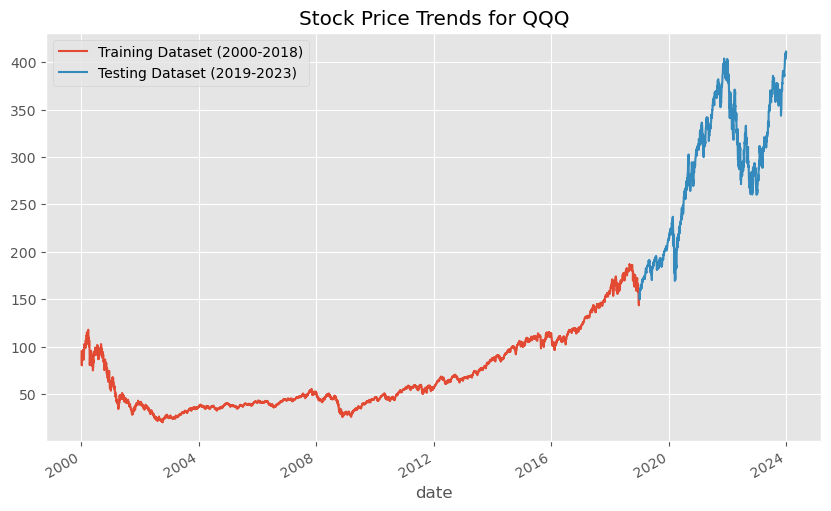

In [57]:
df['close']['2000-01-01':'2018-12-31'].plot(figsize=(10,6), legend=True)
df['close']['2019-01-01':].plot(figsize=(10,6), legend=True)

plt.legend(["Training Dataset (2000-2018)", "Testing Dataset (2019-2023)"])
plt.title("Stock Price Trends for QQQ")
plt.show()

In [60]:
df.head()

,open,high,low,close,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,,,,,,
2000-01-03,96.1875,96.1875,90.7500,94.75000,36345200,5.43,7.5,2.826171,4.1,111.3
2000-01-04,92.0000,93.5000,87.9375,88.25000,33786600,5.38,7.5,2.826171,4.1,111.3
2000-01-05,87.5000,89.6250,84.2500,86.00000,42496600,5.41,7.5,2.826171,4.1,111.3
2000-01-06,86.8750,88.0000,79.7500,80.09375,37134800,5.54,7.5,2.826171,4.1,111.3
2000-01-07,82.9375,90.0000,82.5000,90.00000,28138200,5.61,7.5,2.826171,4.1,111.3


In [61]:
train = df['2000-01-01':'2018-12-31'].values
test = df['2019-01-01':].values

In [64]:
mm_scaler = MinMaxScaler(feature_range=(0,1))

train_scaled = mm_scaler.fit_transform(train)

In [65]:
np.shape(train)

(4779, 10)

In [80]:
X_train, y_train = list(), list()
train_size = len(train_scaled)
timesteps = 30

for iteration in range(timesteps, train_size):
    X_train.append(train_scaled[iteration - timesteps: iteration, :])
    y_train.append(train_scaled[iteration, 3])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [85]:
X_train.shape

(4749, 30, 10)

In [103]:
# Scale all features (open, high, low, close, volume, etc.) for both train and test data
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the scaler on the training data (train includes all features)
train_scaled = scaler.fit_transform(train)

# Transform the test data using the already fitted scaler
test_scaled = scaler.transform(test)

# Prepare the data for LSTM model (create sequences for both train and test)
X_train, y_train = list(), list()
X_test = list()

# Prepare sequences for the training set
for i in range(timesteps, len(train_scaled)):
    X_train.append(train_scaled[i - timesteps:i, :])  # Use all features
    y_train.append(train_scaled[i, 3])  # Target is the 'close' price, which is at index 3

# Prepare sequences for the testing set
for i in range(timesteps, len(test_scaled)):
    X_test.append(test_scaled[i - timesteps:i, :])  # Use all features

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

# Reshape the data for LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Now your model can be trained on X_train and evaluated on X_test


In [104]:
INPUT_RECURRENT_LAYER =   LSTM(50,
                               return_sequences=True,
                               input_shape=(30, 10))
SECOND_RECURRENT_LAYER =  LSTM(50,
                               return_sequences=True)
THIRD_RECURRENT_LAYER =   LSTM(50,
                               return_sequences=True)
FOURTH_RECURRENT_LAYER =  LSTM(50)

# Four dropout regularization layers
FIRST_DROPOUT_LAYER =     Dropout(0.2)
SECOND_DROPOUT_LAYER =    Dropout(0.2)
THIRD_DROPOUT_LAYER =     Dropout(0.2)
FOURTH_DROPOUT_LAYER =    Dropout(0.2)

# One dense connective layer for prediction output
OUTPUT_CONNECTIVE_LAYER = Dense(1)

In [105]:
model = Sequential()

model.add(INPUT_RECURRENT_LAYER)
model.add(FIRST_DROPOUT_LAYER)
model.add(SECOND_RECURRENT_LAYER)
model.add(SECOND_DROPOUT_LAYER)
model.add(THIRD_RECURRENT_LAYER)
model.add(THIRD_DROPOUT_LAYER)
model.add(FOURTH_RECURRENT_LAYER)
model.add(FOURTH_DROPOUT_LAYER)
model.add(OUTPUT_CONNECTIVE_LAYER)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 50)            12200     
                                                                 
 dropout_8 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_9 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

In [106]:
model.compile(optimizer="rmsprop",
              loss="mean_squared_error")

In [107]:
history = model.fit(X_train, y_train,
                    epochs=10, batch_size=32,
                    verbose=True)

Epoch 1/10
149/149 [==============================] - 33s 114ms/step - loss: 0.0076
Epoch 2/10
149/149 [==============================] - 19s 126ms/step - loss: 0.0036
Epoch 3/10
149/149 [==============================] - 20s 135ms/step - loss: 0.0028
Epoch 4/10
149/149 [==============================] - 16s 107ms/step - loss: 0.0024
Epoch 5/10
149/149 [==============================] - 16s 108ms/step - loss: 0.0022
Epoch 6/10
149/149 [==============================] - 16s 107ms/step - loss: 0.0018
Epoch 7/10
149/149 [==============================] - 15s 102ms/step - loss: 0.0017
Epoch 8/10
149/149 [==============================] - 15s 103ms/step - loss: 0.0015
Epoch 9/10
149/149 [==============================] - 16s 104ms/step - loss: 0.0015
Epoch 10/10
149/149 [==============================] - 16s 105ms/step - loss: 0.0014


In [110]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Concatenate zeros for the non-target features (9 features), so the shape matches the original data (10 columns in total)
# Ensure predictions are reshaped to be in the correct shape for concatenation
predictions_reshaped = np.concatenate((np.zeros((predictions.shape[0], 9)), predictions), axis=1)

# Use inverse_transform with the reshaped predictions
predictions_rescaled = mm_scaler.inverse_transform(predictions_reshaped)[:, -1]


39/39 [==============================] - 1s 30ms/step


In [113]:
# Ensure y_test is a NumPy array and reshape it to be 2D
y_test = y_test.values.reshape(-1, 1)  # Convert Series to NumPy array and reshape

# Concatenate zeros for the non-target features (9 features)
y_test_reshaped = np.concatenate((np.zeros((y_test.shape[0], 9)), y_test), axis=1)

# Use inverse_transform with the reshaped y_test values
y_test_rescaled = mm_scaler.inverse_transform(y_test_reshaped)[:, -1]


In [114]:
# Make predictions
predictions = model.predict(X_test)


39/39 [==============================] - 1s 30ms/step


In [115]:
# Reshape predictions to match the scaler's expected input shape
predictions_reshaped = np.concatenate((np.zeros((predictions.shape[0], 9)), predictions), axis=1)

# Inverse transform the predictions
predictions_rescaled = mm_scaler.inverse_transform(predictions_reshaped)[:, -1]


In [117]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R-squared
r2 = r2_score(y_test_rescaled, predictions_rescaled)
print(f'R-squared: {r2}')


ValueError: Found input variables with inconsistent numbers of samples: [1812, 1228]

In [98]:
# Get target data for both train and test periods
target = pd.concat((df['close']['2000-01-01':'2018-12-31'], df['close']['2019-01-01':]), axis=0)

# Prepare testing data from the target
testing_values = target[len(target) - len(test) - timesteps:].values
testing_values = testing_values.reshape(-1, 1)  # Reshape the values for scaling
testing_values = mm_scaler.transform(testing_values)  # Apply the same scaling as training data

# Prepare the sequences for test data (X_test)
X_test = list()
for i in range(timesteps, len(testing_values)):
    X_test.append(testing_values[i - timesteps:i, 0])  # Use the last 'timesteps' data points

X_test = np.array(X_test)  # Convert to numpy array

# Reshape the data for LSTM (samples, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions using the trained model
predictions = model.predict(X_test)

# Inverse transform the predicted values back to the original scale
predictions = mm_scaler.inverse_transform(predictions)


ValueError: X has 1 features, but MinMaxScaler is expecting 10 features as input.

In [ ]:
train = df['2000-01-01':'2018-12-31'].values
test = df['2019-01-01':].values

___

### Classical ML

In [48]:
test_df = df.copy()
test_df = test_df.drop(columns=['high', 'low'])
test_df.head()

,open,close,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,,,,
2000-01-03,96.1875,94.75000,36345200,5.43,7.5,2.826171,4.1,111.3
2000-01-04,92.0000,88.25000,33786600,5.38,7.5,2.826171,4.1,111.3
2000-01-05,87.5000,86.00000,42496600,5.41,7.5,2.826171,4.1,111.3
2000-01-06,86.8750,80.09375,37134800,5.54,7.5,2.826171,4.1,111.3
2000-01-07,82.9375,90.00000,28138200,5.61,7.5,2.826171,4.1,111.3


In [50]:
X, y = test_df.drop(columns=['close']), test_df['close']

In [ ]:
# Closing price will be target value. Dropped adj close as it does not make sense as a predictor.
# X, y = df.drop(columns=['high', 'low', 'close', 'adj_close']), df['close']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=42)

In [38]:
def test_regression_models(X_train, y_train):
    # Adjustments
    CV = 10
    SCORING = 'neg_mean_squared_error' 
    
    # Define the models to be tested
    models = {
        "Linear Regression": LinearRegression(),
        "K-Nearest Neighbors": KNeighborsRegressor(),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "Support Vector Regressor": SVR()
    }
    
    # Initialize results dictionary to store metrics for each model
    results = {
        "Model": [],
        "Mean Squared Error": [],
        "Spread (std)": [],
        "Train Time (s)": [],
        "Memory Usage (MB)": []
    }
    
    # Perform model evaluation for each model
    for model_name, model in models.items():
        # Measure training time
        start_train_time = time.time()

        # Perform k-fold cross-validation to evaluate the model on the training data
        cv_scores = cross_val_score(model, X_train, y_train, cv=CV, scoring=SCORING)

        end_train_time = time.time()
        train_time = end_train_time - start_train_time

        # Measure memory usage (in MB)
        memory_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)
        
        # Convert MSE scores to positive values
        mse_scores = -cv_scores

        # Store the metrics in the results dictionary
        results["Model"].append(model_name)
        results["Mean Squared Error"].append(round(np.mean(mse_scores), 4))
        results["Spread (std)"].append(round(np.std(mse_scores), 4))
        results["Train Time (s)"].append(round(train_time, 4))
        results["Memory Usage (MB)"].append(round(memory_usage, 0))
        
    # Create a DataFrame to display the results
    results_df = pd.DataFrame(results)
    
    # Print the results
    return results_df


In [39]:
test_regression_models(X_train, y_train)

,Model,Mean Squared Error,Spread (std),Train Time (s),Memory Usage (MB)
0,Linear Regression,3.4189,0.6624,0.0858,174.0
1,K-Nearest Neighbors,10331.0880,950.1741,0.1458,174.0
2,Decision Tree,7.3420,1.3792,0.8008,174.0
3,Random Forest,4.0990,0.6826,63.5419,168.0
4,Gradient Boosting,3.9976,0.6586,15.6533,169.0
5,XGBoost,5.0725,0.9339,2.3402,183.0
6,Support Vector Regressor,10779.2422,1137.4130,15.5269,203.0


Linear Regression is the top performin model with Random Forest coming second.

In [52]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.4f}')
print(f'R²: {r2:.4f}')

MSE: 3.5344
R²: 0.9996


___